In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             roc_curve, precision_recall_curve, average_precision_score)
from sklearn.feature_selection import SelectFromModel

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# optional model libs
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import shap
import joblib
import warnings
warnings.filterwarnings('ignore')



In [3]:
df = pd.read_excel('loan.xlsx')  # or pd.read_csv('loan.csv')
df.head()
df.info()
df.isnull().sum().sort_values(ascending=False).head(20)
df['Loan_Status'].value_counts(normalize=True)  # target balance


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


Loan_Status
Y    0.687296
N    0.312704
Name: proportion, dtype: float64

In [5]:
df['Loan_Status'] = df['Loan_Status'].map({'Y':1,'N':0})


In [7]:
# Example column names are the typical loan dataset ones. Adjust if yours differ.
df['Dependents'].replace('3+', 3, inplace=True)
df['Dependents'] = df['Dependents'].astype(float)

# Feature engineering
df['TotalIncome'] = df[['ApplicantIncome','CoapplicantIncome']].sum(axis=1)
# Debt/Income style features (avoid divide by zero)
df['LoanAmount'] = df['LoanAmount'].fillna(df['LoanAmount'].median())
df['LoanToIncome'] = df['LoanAmount'] / (df['TotalIncome'] + 1e-6)
df['EMIapprox'] = df['LoanAmount'] / ((df['Loan_Amount_Term'].fillna(360) / 12) + 1e-6)
df['Income_per_dep'] = df['TotalIncome'] / (df['Dependents'] + 1)

# Flag features
df['HighIncome'] = (df['TotalIncome'] > df['TotalIncome'].median()).astype(int)
df['HasCoapplicant'] = (df['CoapplicantIncome'] > 0).astype(int)


In [11]:
num_cols = df.select_dtypes(include=[np.number]).columns.drop('Loan_Status').tolist()
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()

# detect skewed numeric features (apply log1p)
skew_thresh = 0.75
skew_vals = df[num_cols].skew().abs()
skewed_cols = skew_vals[skew_vals > skew_thresh].index.tolist()
non_skew_cols = [c for c in num_cols if c not in skewed_cols]

from sklearn.preprocessing import FunctionTransformer
log_transformer = FunctionTransformer(np.log1p, validate=False)

num_pipeline_skew = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('log', log_transformer),
    ('scaler', StandardScaler())
])
num_pipeline_regular = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers = [
        ('num_skew', num_pipeline_skew, skewed_cols),
        ('num_reg', num_pipeline_regular, non_skew_cols),
        ('cat', cat_pipeline, cat_cols)
    ],
    remainder='drop'
)


In [13]:
X = df.drop(columns=['Loan_Status'])
y = df['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [15]:
def make_pipeline_with(clf, use_smote=True):
    steps = [('preproc', preprocessor)]
    if use_smote:
        # imblearn pipeline has to be used when adding sampler
        return ImbPipeline(steps + [('smote', SMOTE(random_state=42)), ('clf', clf)])
    else:
        steps += [('clf', clf)]
        return Pipeline(steps)

models = {
    'RandomForest': make_pipeline_with(RandomForestClassifier(random_state=42)),
    'XGBoost': make_pipeline_with(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
    'LightGBM': make_pipeline_with(LGBMClassifier(random_state=42)),
    'CatBoost': make_pipeline_with(CatBoostClassifier(verbose=0, random_state=42)),
    'Logistic': make_pipeline_with(LogisticRegression(max_iter=1000))
}

from sklearn.model_selection import cross_validate
scoring = ['accuracy','precision','recall','f1','roc_auc']
results = {}
for name, pipe in models.items():
    cvres = cross_validate(pipe, X_train, y_train, cv=5, scoring=scoring, n_jobs=-1)
    results[name] = {k: np.mean(v) for k,v in cvres.items()}
pd.DataFrame(results).T


,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
RandomForest,1.332399,0.117350,0.753515,0.771414,0.910887,0.835307,0.735428
XGBoost,1.092364,0.027578,0.751536,0.794857,0.860623,0.826172,0.743745
LightGBM,2.223669,0.078002,0.745393,0.792026,0.854565,0.821651,0.740929
CatBoost,33.081847,0.183631,0.769882,0.780415,0.925988,0.846656,0.733989
Logistic,0.261863,0.073119,0.767904,0.783821,0.914179,0.843751,0.723574


In [23]:
from imblearn.pipeline import Pipeline 
base_estimators = [
    ('rf', RandomForestClassifier(n_estimators=200, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric='logloss', random_state=42)),
    ('lgb', LGBMClassifier(n_estimators=200, random_state=42))
]

stack = Pipeline([
    ('preproc', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('stacker', StackingClassifier(estimators=base_estimators, final_estimator=LogisticRegression(), n_jobs=-1, passthrough=True))
])

stack.fit(X_train, y_train)
y_pred = stack.predict(X_test)
print('F1:', f1_score(y_test, y_pred))


F1: 0.8786127167630058


              precision    recall  f1-score   support

           0       0.88      0.58      0.70        38
           1       0.84      0.96      0.90        85

    accuracy                           0.85       123
   macro avg       0.86      0.77      0.80       123
weighted avg       0.85      0.85      0.84       123

ROC AUC: 0.8582043343653251


Text(0.5, 1.0, 'Confusion matrix')

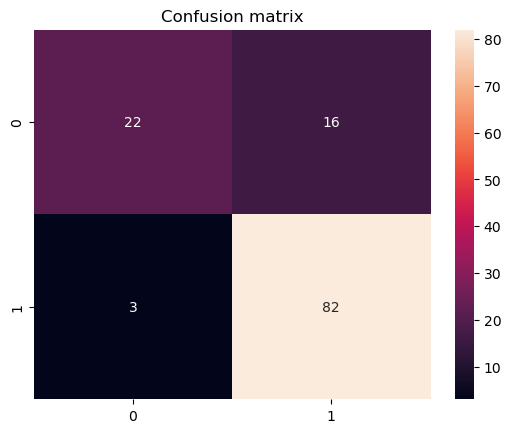

In [25]:
best = rs_xgb.best_estimator_  # or rs_rf.best_estimator_ or stack
y_proba = best.predict_proba(X_test)[:,1]
y_pred = best.predict(X_test)

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d'); plt.title('Confusion matrix')


In [35]:
# Save the whole pipeline (preprocessor + model) for deployment
final_model = rs_xgb.best_estimator_  # or whichever is best
joblib.dump(final_model, 'loan_approval_pipeline.joblib')


['loan_approval_pipeline.joblib']